# GEDI: Scalability, Performance & Data Exploration

**author**: Stefanie Lumnitz, stefanie.lumnitz@esa.int

**goal**: possibilities for scalability and performance for large scale GEDI data processing

**content**:
* Testing xarray for ndim data processing
    * Introduction to xarray
    * How to make use of xarray for GEDI data processing
    * Examples
* Testing usability of Dask
    * handling and creating dask.Arrays and dask.DataFrame

In [5]:
import h5py
import os
import pandas as pd
import numpy as np

In [21]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"

# xarray

[Xarray](http://xarray.pydata.org/en/stable/why-xarray.html) supports multi-dimensional data arrays. In comparison to pandas, it is made for processing multi-dimensional arrays and allows for intelligently labeling arrays (i.e. geolocation, date, time) to be used for processing. Additionally, it builds on top of dask to allow for parallel processing and scalability. It tightly integrates with pandas, numpy, dask and matplotlib. An introductory talk by core-developer Stephan Hoyer can be found [here](https://www.youtube.com/watch?v=X0pAhJgySxk) and a software paper introducing xarray can be found [here](https://openresearchsoftware.metajnl.com/articles/10.5334/jors.148/) and a nice introductory tutorial can be found [here](https://geohackweek.github.io/nDarrays/01-introduction/).

It is modelled after the netCDF data format and tightly integrated with it. However, according to xarrays author and core-developer, Xarray will [never be able to read arbitrary HDF5 files](https://github.com/pydata/xarray/issues/66#issuecomment-485291578) that are not also structured similarly to netCDF files.
**Update:** After testing it does seem as GEDI hdf5 format could e supported.

### How to make use of xarray for GEDI data processing?

Specific information stored in HDF5 format could be extracted and reformatted into an `xarray.Dataset` to make use of it's functionality for multidimensional data processing and parallel computing. A translation of hdf5 datasets into xarray or pandas could be of benefit. This is to be explored further.

Example of different viz tools tested: https://stackoverflow.com/questions/5854515/interactive-large-plot-with-20-million-sample-points-and-gigabytes-of-data

**test**:
* Note: GEDI .h5 data is not provided with common netCDF standards. This means reading gedi data into xarray requires a custom wrapper or some finesse.
* `xarray.open_mfdataset` cannot be used with faster [h5netcdf engine](https://github.com/shoyer/h5netcdf/issues/43), but relies on `engine='netcdf4'`
* requires `conda/pip install netcdf4`
* we can only load one Beam at a time as dataset using the standard `xarray.open_mfdataset` functionality. We also cannot read subgroups wihtin the beam.
* however, it is possible to read single `xarray.DataArray`'s from gedi's hdf5 format
* xarray is best used for multidimensional arrays or tables, though the majority of GEDI data provided in 1D arrays which suggests pandas could be sufficient for data analysis
* GEDI data has to be pivoted in a multidimensional array with lat, lon in order to make use of coordiantes (see [here](https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa). As a workaroudn one can assign `lat, lon` as a Multiindex and unstack after. This procedure is heavy on RAM.
* Support for direclty working wiht Multiindexes wihtout unstacking is currently developed slowly.
* It might be worth learning more about sparse arrays and utilising sparse arrays for GEDI data processing.
* In order to parallelize xarray well, solid knowledge of dask is needed

**result**: Xarray is a great tool for multidimensional data, raster data, data provided in netCDF and tif files. It might be a great choice when dealing with multitemporal or multi-beam GEDI data processing, eventhought his data will require a wrapper for reading the .h5 file

### Examples

In [31]:
import xarray as xr

#### 1 .Example for loading the cover dataset into an xarray.DataArray:

In [32]:
%time
with h5py.File(file_path_2B, 'r') as f:
    lat = f["BEAM0001/geolocation/lat_lowestmode"][...]
    lon = f["BEAM0001/geolocation/lon_lowestmode"][...]
    #height = f["BEAM0001/rh100"][...]
    cover = f["BEAM0001/cover"][...]
    f.close()

xr_cover = xr.DataArray(data=cover,
                     coords={"lat":(['x'], lat),
                             "lon":(['x'], lon)},
                     dims =["x"])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [33]:
xr_cover

<xarray.DataArray (x: 343295)>
array([0.01746909, 0.0075371 , 0.02107655, ..., 0.01430902, 0.02038702,
       0.01076234], dtype=float32)
Coordinates:
    lat      (x) float64 -24.19 -24.19 -24.19 -24.19 ... -33.52 -33.52 -33.52
    lon      (x) float64 -90.18 -90.18 -90.18 -90.18 ... 125.3 125.3 125.3 125.3
Dimensions without coordinates: x

In [34]:
xr_cover.data.shape

(343295,)

#### 2. loading the entire group 'BEAM0001' into an xarray.Dataset. 

Note: 
* We require an install of `pip/conda install netcdf4`
* Loading data using is currently not supported yet, but might be with future versions `pip/conda install h5netcdf`

In order to support pivoting from 1D to 2D arrays through Multiindexing we need to utilize pandas:

In [35]:
def midx_coords(file_path_2B, beam='BEAM0001'):
    with h5py.File(file_path_2B, 'r') as f:
        lat = f[beam+"/geolocation/lat_lowestmode"][...]
        lon = f[beam+"/geolocation/lon_lowestmode"][...]
        f.close()
        
    midx = pd.MultiIndex.from_arrays([lat, lon],
                                    names=('lat', 'lon'))
    return lat, lon, midx

In [36]:
lat, lon, midx = midx_coords(file_path_2B, beam='BEAM0001')

In [37]:
%%time

with xr.open_mfdataset(file_path_2B, group='BEAM0001',
                       chunks=100000,
                         engine= 'netcdf4',
                         combine='nested',
                         concat_dim='phony_dim_3') as xarr:
    xarr

CPU times: user 616 ms, sys: 373 ms, total: 989 ms
Wall time: 1.7 s


In [38]:
xarr

<xarray.Dataset>
Dimensions:                 (phony_dim_3: 343295, phony_dim_4: 30, phony_dim_5: 11613761)
Dimensions without coordinates: phony_dim_3, phony_dim_4, phony_dim_5
Data variables:
    algorithmrun_flag       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    beam                    (phony_dim_3) uint16 dask.array<chunksize=(100000,), meta=np.ndarray>
    channel                 (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    cover                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    cover_z                 (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    delta_time              (phony_dim_3) datetime64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    fhd_normal              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    l2a_quality_flag        (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    l2b_quality_flag        (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    master_frac             (phony_dim_3) timedelta64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    master_int              (phony_dim_3) timedelta64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    num_detectedmodes       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    omega                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pai                     (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pai_z                   (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    pavd_z                  (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    pgap_theta              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pgap_theta_error        (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pgap_theta_z            (phony_dim_3, phony_dim_5) float32 dask.array<chunksize=(343295, 100000), meta=np.ndarray>
    rg                      (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rh100                   (phony_dim_3) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhog                    (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhog_error              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhov                    (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhov_error              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rossg                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rv                      (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_range_highestreturn  (phony_dim_3) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_sample_count         (phony_dim_3) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_sample_start_index   (phony_dim_3) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    selected_l2a_algorithm  (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    selected_rg_algorithm   (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    sensitivity             (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    shot_number             (phony_dim_3) uint64 dask.array<chunksize=(100000,), meta=np.ndarray>
    stale_return_flag       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    surface_flag            (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
Attributes:
    wp-l2-l2b_githash:  1eac4e6b60cf8d344d2cb1d65b5149bbcae8375f
    wp-l2-l2b_version:  20191127.0.0
    description:        Coverage beam

We can see that `xarray.open_mfdataset()` did not read in subgroups of our beam group.

In order to work with coordinates, we need to set dimension `phony_dim_3` to be a Multiindex of `(lat, lon)`

In [39]:
xarr.coords['phony_dim_3'] = ('phony_dim_3', midx)

In [40]:
xarr

<xarray.Dataset>
Dimensions:                 (phony_dim_3: 343295, phony_dim_4: 30, phony_dim_5: 11613761)
Coordinates:
  * phony_dim_3             (phony_dim_3) MultiIndex
  - lat                     (phony_dim_3) float64 -24.19 -24.19 ... -33.52
  - lon                     (phony_dim_3) float64 -90.18 -90.18 ... 125.3 125.3
Dimensions without coordinates: phony_dim_4, phony_dim_5
Data variables:
    algorithmrun_flag       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    beam                    (phony_dim_3) uint16 dask.array<chunksize=(100000,), meta=np.ndarray>
    channel                 (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    cover                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    cover_z                 (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    delta_time              (phony_dim_3) datetime64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    fhd_normal              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    l2a_quality_flag        (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    l2b_quality_flag        (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    master_frac             (phony_dim_3) timedelta64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    master_int              (phony_dim_3) timedelta64[ns] dask.array<chunksize=(100000,), meta=np.ndarray>
    num_detectedmodes       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    omega                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pai                     (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pai_z                   (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    pavd_z                  (phony_dim_3, phony_dim_4) float32 dask.array<chunksize=(100000, 30), meta=np.ndarray>
    pgap_theta              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pgap_theta_error        (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    pgap_theta_z            (phony_dim_3, phony_dim_5) float32 dask.array<chunksize=(343295, 100000), meta=np.ndarray>
    rg                      (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rh100                   (phony_dim_3) int16 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhog                    (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhog_error              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhov                    (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rhov_error              (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rossg                   (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rv                      (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_range_highestreturn  (phony_dim_3) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_sample_count         (phony_dim_3) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    rx_sample_start_index   (phony_dim_3) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    selected_l2a_algorithm  (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    selected_rg_algorithm   (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    sensitivity             (phony_dim_3) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    shot_number             (phony_dim_3) uint64 dask.array<chunksize=(100000,), meta=np.ndarray>
    stale_return_flag       (phony_dim_3) uint8 dask.array<chunksize=(100000,), meta=np.ndarray>
    surface_flag            (phony_dim_3) uint8 dask.array<chunksiz

In [41]:
cover = xarr.cover
cover

<xarray.DataArray 'cover' (phony_dim_3: 343295)>
dask.array<open_dataset-4b023491c3469a007676a931068f3b7dcover, shape=(343295,), dtype=float32, chunksize=(100000,), chunktype=numpy.ndarray>
Coordinates:
  * phony_dim_3  (phony_dim_3) MultiIndex
  - lat          (phony_dim_3) float64 -24.19 -24.19 -24.19 ... -33.52 -33.52
  - lon          (phony_dim_3) float64 -90.18 -90.18 -90.18 ... 125.3 125.3
Attributes:
    long_name:    Total cover
    units:        -
    description:  Total canopy cover, defined as the percent of the ground co...
    valid_range:  [0. 1.]
    coordinates:  geolocation/delta_time geolocation/lat_lowestmode geolocati...

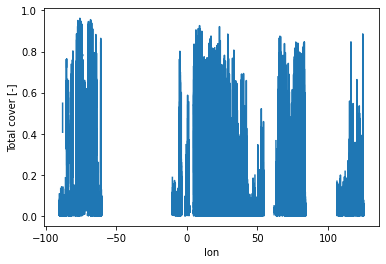

In [42]:
cover.plot(x='lon')

In [43]:
cover_gridded = cover[:1000].unstack('phony_dim_3')

In [45]:
cover_gridded

<xarray.DataArray 'cover' (lat: 1000, lon: 1000)>
dask.array<reshape, shape=(1000, 1000), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -24.19 -24.19 -24.19 -24.19 ... -23.8 -23.8 -23.8
  * lon      (lon) float64 -90.18 -90.18 -90.18 -90.18 ... -89.82 -89.82 -89.82
Attributes:
    long_name:    Total cover
    units:        -
    description:  Total canopy cover, defined as the percent of the ground co...
    valid_range:  [0. 1.]
    coordinates:  geolocation/delta_time geolocation/lat_lowestmode geolocati...

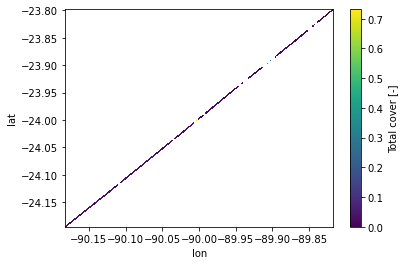

In [44]:
cover_gridded.plot.pcolormesh()

`pcolormesh()` visualization with Multiindex is unfortunately not supported yet. Hence we have to unstack our data first.

CPU times: user 51.8 ms, sys: 4.79 ms, total: 56.6 ms
Wall time: 68.7 ms


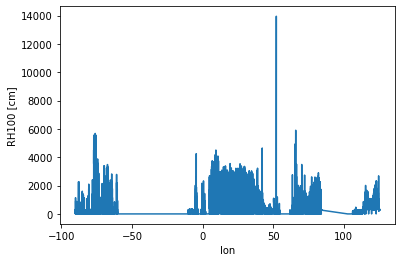

In [46]:
%%time
%matplotlib inline
xarr['rh100'].plot(x='lon')

In [47]:
xarr.close()

# dask

Thanks to the Dask team to provide a fantastic [tutorial](https://github.com/dask/dask-tutorial) introducing dask:

Dask provides multi-core and distributed parallel execution on larger-than-memory datasets.
In comparison, numpy and pandas are pretty fast already, it's not worth using dask on something that is fast already and fit's into memory on a single machine. Numpy and pandas also support running algorithms in threads. 

**Dask is really good for heavy on memory computations, when your dataset does not fit into memory, or heavy on CPU usage. Worth to call the Dask version here! Requires good knowledge of chunking**

We can think of Dask at a high and a low level
* **High level collections**: Dask provides high-level Array, Bag, and DataFrame collections that mimic NumPy, lists, and Pandas but can operate in parallel on datasets that don't fit into memory. Dask's high-level collections are alternatives to NumPy and Pandas for large datasets.
* **Low Level schedulers**: Dask provides dynamic task schedulers that execute task graphs in parallel. These execution engines power the high-level collections mentioned above but can also power custom, user-defined workloads. These schedulers are low-latency (around 1ms) and work hard to run computations in a small memory footprint. Dask's schedulers are an alternative to direct use of threading or multiprocessing libraries in complex cases or other task scheduling systems like Luigi or IPython parallel.


Especially the High level collections make dask a powerful tool to help global GEDI data analysis.

test:
* use dask arrays rather than dask.dataframe for custom hdf5 files (REVIEW)
* call `dask.compute(x, y, z)` to allow for sharing of intermediate computations!
* you can check task graphs, visualize them and save them through `da.visualize(filename='graph.pdf')`
* only recommended for use when working with larger-than-memory data or if a distributed scheduler, working across a cluster is needed. i.e. if pandas breaks with `MemoryError:...`. Otherwise pandas is recommended, as it provides more functionality.
* to check what can be parallelized and how much speed up can be achieved, view the graph.

## Converting hdf5 datasets into a dask.Dataframe

Similarly to notebook 02, we will investigate the use of `dask.Dataframe` to explore our gedi hdf5 dataset.

In [1]:
import h5py
import dask.array as da
import dask.dataframe as dd
import dask
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%load_ext memory_profiler

In [18]:
def hdf2dd(h5_file, all_beams=True,
           columns=['beam', 'cover',
                   'fhd_normal', 'pai',
                   'geolocation/lat_lowestmode', 'geolocation/lon_lowestmode'],
           beams=None,
           chunks=(100000,)):
    """create dask.Dataframe from h5 file
    
    To-Do: cover-z shape (x, 30) not 1D! Allow for nD arrays
    
    Parameters
    ----------
    h5_file: open h5py.File
        h5 file to load into a df
    all_beams: bool
        If True all Beams will be loaded if False, beams need to be specified
    columns: list of str
        Specification of subgroups pointing towards data
        that should be included
    beams: list of str
        Specification of the group of Beams to load, Default=None
    
    Returns
    -------
    GEDIdf: dask.DataFrame object
        Dataframe containing specified information
        
    """
    
    # allow for all and single beam analysis
    if all_beams is True:
        # raw_beams = list(h5_file.keys())
        # rm all non beam keys
        beams = [beam for beam in list(h5_file) if 'BEAM' in beam]
    else:
        beams = beams
    
    # unpack and format values
    ds = []
    for beam in beams:
        dsets = []
        for val in columns:
            values = h5_file[str(beam)+'/'+str(val)][...]
            dsets.append(values)
        arrays = [da.from_array(dset, chunks=chunks) for dset in dsets]
        x = da.stack(arrays, axis=0)
        ds.append(x)

    data = da.concatenate(ds, axis=1)
    
    # write dataframe
    GEDIdf = dask.dataframe.from_array(data.T, columns=columns)
    
        # replace -9999 missing values by np.nan
    GEDIdf = GEDIdf.replace(to_replace= -9999, value=np.nan)
    
    if 'cover' in columns:
        GEDIdf['cover'] = GEDIdf['cover']*100 #cm to m
    else:
        pass
    
    if 'rh100' in columns:
        GEDIdf['rh100'] = GEDIdf['rh100']*0.01 #cm to m
    
    return GEDIdf

In [3]:
%%time
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"
with h5py.File(file_path_2B, 'r') as h5_file:
    ddf = hdf2dd(h5_file)

CPU times: user 360 ms, sys: 66.7 ms, total: 427 ms
Wall time: 749 ms


In [4]:
ddf

,beam,cover,fhd_normal,pai,geolocation/lat_lowestmode,geolocation/lon_lowestmode
npartitions=38,,,,,,
0,float64,float64,float64,float64,float64,float64
100000,...,...,...,...,...,...
...,...,...,...,...,...,...
3391054,...,...,...,...,...,...
3434224,...,...,...,...,...,...


In [5]:
%%memit
ddf.cover.max().compute()

peak memory: 275.37 MiB, increment: 44.75 MiB


In [6]:
%%time
ddf.pai.max().compute()

CPU times: user 630 ms, sys: 116 ms, total: 746 ms
Wall time: 527 ms


8.710798263549805

In [7]:
%%time
ddf.cover.mean().compute()

CPU times: user 543 ms, sys: 197 ms, total: 740 ms
Wall time: 546 ms


9.892064604633205

### Performance comparison of pd and dask

Let's compare our new times to the pandas version of the dataframe clacualtions in notebook 02:

In [8]:
import pandas as pd

In [2]:
def hdf2df(h5_file, all_beams=True,
           columns=['beam', 'cover',
                   'fhd_normal', 'pai',
                   'geolocation/lat_lowestmode', 'geolocation/lon_lowestmode'],
           beams=None):
    """create pandas.Dataframe from h5 file
    
    To-Do: cover-z shape (x, 30) not 1D! Allow for nD arrays
    
    Parameters
    ----------
    h5_file: open h5py.File
        h5 file to load into a df
    all_beams: bool
        If True all Beams will be loaded if False, beams need to be specified
    columns: list of str
        Specification of subgroups pointing towards data
        that should be included
    beams: list of str
        Specification of the group of Beams to load, Default=None
    
    Returns
    -------
    GEDIdf: pd.DataFrame object
        Dataframe containing specified information
        
    """
    
    # allow for all and single beam analysis
    if all_beams is True:
        #raw_beams = list(h5_file.keys())
        # rm all non beam keys
        beams = [beam for beam in list(h5_file) if 'BEAM' in beam]
    else:
        beams = beams
    
    # convert values into pandas.Dataframe
    GEDIlist = []
    
    # unpack values per beam
    for beam in beams:
        df = pd.DataFrame()
        for val in columns:
            values = h5_file[beam+'/'+val][...]
            df[val]=values 
        GEDIlist.append(df)

    
    # concatenate single BEAM dfs
    GEDIdf = pd.concat(GEDIlist)

    # replace -9999 missing values by np.nan
    GEDIdf = GEDIdf.replace(to_replace= -9999, value=np.nan)
    
    if 'cover' in columns:
        GEDIdf['cover'] = GEDIdf['cover']*100 #cm to m
    else:
        pass
    
    if 'rh100' in columns:
        GEDIdf['rh100'] = GEDIdf['rh100']*0.01 #cm to m
        
    #GEDIdf = GEDIdf[GEDIdf.cover != -9999]
    return GEDIdf

In [19]:
%%timeit
with h5py.File(file_path_2B, 'r') as f_2B:
    dd = hdf2dd(f_2B)
    mean_cover = dd.cover.mean().compute()

1.19 s ± 54.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
with h5py.File(file_path_2B, 'r') as f_2B:
    hdf = hdf2df(f_2B)
    mean_cover_pd = hdf.cover.mean()

1.58 s ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%memit
with h5py.File(file_path_2B, 'r') as f_2B:
    dd = hdf2dd(f_2B)
    mean_cover = dd.cover.mean().compute()

peak memory: 530.13 MiB, increment: 16.05 MiB


In [14]:
%%memit
with h5py.File(file_path_2B, 'r') as f_2B:
    hdf = hdf2df(f_2B)
    mean_cover_pd = hdf.cover.mean()

peak memory: 939.33 MiB, increment: 409.09 MiB


In [20]:
mean_cover

9.892064604633205

In [21]:
mean_cover_pd

9.892062

As we can see using `dask` improves both speed and memory usage for simple analysis and statistical exploration of the data. However, there are limit's to how `dask` can be utilized and how much speed up is supported. The utilization of `dask` for larger-than-memory datasets is not trivial and needs to be considered carefully. Knowledge and testing of chunking is important.

## Using Dask.delayed for trivial parallel processing

* Work-flow:
    1. `delayed()` wrapper around what should be parallelized,
    2. `visualize()` to assess the flow,
    3. `compute()` to process results.
* Methods and attribute access on `delayed` objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    >>> df = delayed(pd.read_csv)(fn)
    >>> grouped = df.groupby('x') 
        #will be delayed as well
    ```


* Calling the `.compute()` method works well when you have a single output. When you have multiple outputs you might want to use the `dask.compute` function, i.e.

    ```python
    >>> sums, counts = compute(sums, counts)
    ```


* Use `.visualize()` to plot your execution graph.
* `dd.read_hdf()` is similar to `pd.read_hdf()` and not suitable for GEDI data. Use `xarray` instead, see above.

In [4]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"

In [5]:
%%timeit
with h5py.File(file_path_2B, 'r') as f_2B:
    hdf = dask.delayed(hdf2df)(f_2B)
    mean_cover_pd = hdf.cover.mean().compute()

1.46 s ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%memit
with h5py.File(file_path_2B, 'r') as f_2B:
    hdf = dask.delayed(hdf2df)(f_2B)
    mean_cover_pd = hdf.cover.mean().compute()

peak memory: 582.42 MiB, increment: 24.07 MiB


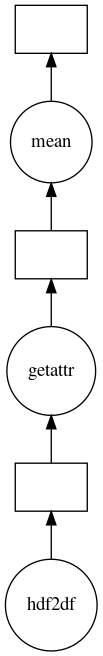

In [8]:
hdf.cover.mean().visualize()

Using `dask.delayed` performs marginally better than using pure pandas, but worse than analyzing the data using a `dask.dataframe`